# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**



##### **Ομάδα 57:**
**Θοδωρής Σωτήρου 03118209**

**Ανδρέας Χατζησάββας 03118701**

**Λουκια Παυλανά 03118711**

In [2]:
!pip install --upgrade pip==21.3.1
!pip install --upgrade numpy==1.21.5
!pip install --upgrade pandas==1.3.5
!pip install --upgrade nltk==3.6.6
!pip install --upgrade scikit-learn==1.0.1
!pip install --upgrade joblib==1.1.0
!pip install -U gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 33.9 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 19.5 MB/s            
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.5 MB/s             
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 33.0 MB/s            
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    U

#### IMPORTS

In [5]:
import numpy as np
import pandas as pd
import nltk
import sys
import scipy as sp
from time import time 
import re
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
import string
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [10]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [11]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 57

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [12]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Come Drink with Me']
['"Wuxia",  "Fantasy Adventure",  "World cinema",  "Action/Adventure",  "Martial Arts Film",  "Action",  "Chinese Movies"']
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import joblib

nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
import re
extrastopwords = ["film", "n't", "movie", "arrive", "performance", "participating",
                    "character","one","two","three","four","five","six","seven","eight","nine","ten","first","second","third","fourth",
                    "fifth","sixth","seventh","eighth","nineth","tenth","much","set","also","make","able","sit","take","anyway","get","today","later",
                    "still","making","often","like","start","time","episode","section","begin","end","start","see","full","open",
                    "main","character","even","every"]
checklist = stopwords.words('english') + list(string.punctuation) + extrastopwords

def first_filter(list_of_words):
    filt_words = []
    for word in list_of_words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filt_words.append(word)
    return filt_words

def preprocess(this_string):
    text_tokens = nltk.word_tokenize(this_string.lower())
    
    tokens_without_sw = [word for word in text_tokens if word not in checklist]
    tokens_without_sw = first_filter(tokens_without_sw)
    
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in tokens_without_sw]
    stem_text = [porter_stemmer.stem(word) for word in lemm_text if (len(word) > 3)]

    cnt = collections.Counter( stem_text)

    #stem_text = [porter_stemmer.stem(word) for word in tokens_without_sw if (len(word) > 2)]
    
    #lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in stem_text]
    
    return(stem_text,cnt)
    
preprocessed_documents = []
prep_doc_cnt = []
for cor in corpus:
    cor = re.sub("[^A-Za-z]+", ' ', cor)
    (preprocessed_documents_instance, prep_doc_cnt_instance) = preprocess(cor)
    preprocessed_documents.append(preprocessed_documents_instance)
    prep_doc_cnt.append(prep_doc_cnt_instance)

In [15]:
new_corpus = []

for corp in preprocessed_documents:
    new_corpus.append(' '.join(corp))
    
joblib.dump(new_corpus, 'new_corpus_persist') 

['new_corpus_persist']

In [16]:
joblib.dump(new_corpus, 'new_corpus.pkl') 

['new_corpus.pkl']

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(new_corpus)
corpus_tf_idf_plain = vectorizer.transform(new_corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [18]:
print(corpus_tf_idf_plain.shape)

(5000, 32245)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [19]:
from numpy import dot
from numpy.linalg import norm

In [20]:
# Function to recommend similar movies based on corpus
def content_recommender(target_movie, max_recommendations, corpus_type):
    # target_movie -> id of the movie
    # max_recommendations -> number of movies to recommend
    
    # find index of given movie if title is given
    if (type(target_movie) == str):
      try:
        ([index], _) = np.where(titles == target_movie)
      except:
        print("Movie " + target_movie + " does not exist in database")
    elif (type(target_movie) == int):
      index = target_movie

    corpus_type = corpus_type.toarray()
    our_corpus = corpus_type[index]
    best_cosines = np.zeros((max_recommendations+1,), dtype='f,i')

    for i in range(len(corpus_type)):
      candidate_corpus = corpus_type[i]
      cos_sim = dot(our_corpus, candidate_corpus)/(norm(our_corpus)*norm(candidate_corpus))
      if (cos_sim > best_cosines[0][0]):
        best_cosines[0] = (cos_sim, i)
        best_cosines.sort()
    best_cosines = best_cosines[::-1]

    print("\033[4mTarget Movie:\033[0m")
    print("\tID:", index)
    print("\tTitle:", titles[index][0])
    print("\tCategories: ", categories[index][0])
    print("\tSummary: ", summaries[index][0])
    print("\033[4mRecommendations:\033[0m")

    for (i, (cos_val, sim_index)) in enumerate(best_cosines):
      print_similar(i+1, sim_index)

    return

def print_similar(order, movie_index):
    if (order == 1):
      return
    elif (order == 2):
      ind = "1st"
    elif (order == 3):
      ind = "2nd"
    elif (order == 4):
      ind = "3rd"
    elif (order > 4):
      ind = str(order-1) + "th"

    print(ind + " reccomendation")
    print("\tID:", movie_index)
    print("\tTitle:", titles[movie_index][0])
    print("\tCategories: ", categories[movie_index][0])
    print("\tSummary: ", summaries[movie_index][0])


content_recommender("Flashback", 5, corpus_tf_idf_plain)

Target Movie:
	ID: 4998
	Title: Flashback
	Categories:  "Action/Adventure",  "Action",  "Comedy"
	Summary:  Huey Walker, a hippie and a former New Left radical  who has been on the run from the law for 20 years for something he did not do, disconnecting Spiro Agnew's train car in Spokane, Washington. John Buckner is an FBI agent who is set to transport Walker back to Spokane for trial. Their journey forces them to cross paths with a corrupt Sheriff Hightower and the two end up fleeing for their lives. As the story progresses, it is revealed that Buckner was raised on a communal farm and that his given name is Free. As Buckner learns to reconcile his past with his present, Walker does as well.
Recommendations:
1st reccomendation
	ID: 3238
	Title: Frantic
	Categories:  "Thriller",  "Mystery",  "Action",  "Psychological thriller",  "Action/Adventure"
	Summary:  Dr. Richard Walker is a surgeon visiting Paris with his wife Sondra for a medical conference. At their hotel, she is unable to un

In [23]:
idgaf = np.zeros((3,),dtype='i,f')
idgaf[0][1] = 1
idgaf[1][1] = 3
idgaf[2][1] = 2
idgaf[0][0] = 77
idgaf[1][0] = 33
idgaf[2][0] = 22
idgaf.sort()
idgaf

array([(22, 2.), (33, 3.), (77, 1.)], dtype=[('f0', '<i4'), ('f1', '<f4')])

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




In [24]:
improved_vectorizer = TfidfVectorizer(min_df = 0.0003,max_df = 0.20)
improved_vectorizer.fit(new_corpus)
corpus_tf_idf_improved = improved_vectorizer.transform(new_corpus)

In [25]:
joblib.dump(corpus_tf_idf_improved, 'corpus_tf_idf_improved.pkl')

['corpus_tf_idf_improved.pkl']

In [17]:
print(corpus_tf_idf_improved.shape)
print(corpus_tf_idf_plain.shape)

(5000, 15592)
(5000, 32245)


### Παρατηρήσεις  Τfidf

Συμπεραίνουμε πως οι ιδανικές παραμέτροι για την βελτιστοποίηση του TfidfVectorizer είναι οι:
1. min_df = 0.0003 όπου δηλαδή αγνοούνται οι λέξεις με μικρή εμφάνιση.
2. max_df = 0.20 όπου αγνοούνται λέξεις με πολύ συχνή εμφάνιση.

Αξίζει να σημειωθεί ότι οι ταινίες που αναλύουμαι είναι πάρα πολλές και ώς επι το πλείστον άγνωστες σε εμάς γιαυτό η αξιολόγση των συνιστόμενων ταινιών ήταν δύσκολη.

#### Πλεονεκτήματα  Τfidf:
1. Πολύ απλό και εύκολο στην εκτέλεση.
2. Φτηνό στην υπολογιστικότητα.

#### Μειωνεκτήματα Tfidf:
1. Δεν αντιλαμβάνεται την βαρύτητα και την σημασια των λέξεων μέσα στην περιγραφή. Για παράδειγμα μπορεί να ταυτίση μια sci-fi ταινια που περιέχει την λέξη "space" δηλαδή το διάστημα με μια άλλη ταινια όπου η λέξη "space" περιγράφει το χωρικό διάστημα.
2. Δεν λαμβάνει υπόψη την σειρά των λέξεων, για παράδειγμα τη φράση "machine learning" δεν θα την χειριστή σαν ένα ενιαίο unit αλλά σαν δύο διαφορετικές λέξεις χάνοντας το σημαντικό νόημα της φράσης.
3. Κάποιες λέξεις stop words οι οποίες μας έχουν διαφύγει και δεν έχουν αφαιρεθεί θα συσχετίσουν ταινίες οι οποίες δεν έχουν σχέση μεταξύ τους ενώ στην πραγματικότητα είναι πολύ διαφορετικές.
4. Κάποια summaries ταινιών είναι πολύ πιο επεξηγηματικά απο άλλα επηρεάζοντας τα αποτελέσματα.

### Cherry Picking

In [26]:
cherry_picking_ids = [296,388,4997]
for id in cherry_picking_ids:
    content_recommender(id,5,corpus_tf_idf_plain)

Target Movie:
	ID: 296
	Title: How to Train Your Dragon
	Categories:  "Adventure",  "Computer Animation",  "Animation",  "Fantasy",  "Comedy",  "Family Film",  "Action"
	Summary:  The island of Berk has been plagued by attacks from dragons that steal their livestock and burn their homes. Hiccup, the awkward son of the village chieftain, Stoick the Vast, uses a cannon contraption he invented and shoots down a dragon he thinks may be a Night Fury, a rare dragon nobody has ever actually seen. Hiccup locates the dragon in the forest, but finds he is unable to kill the helpless animal. Hiccup instead cuts it free, and the dragon disappears into the forest. Meanwhile, Stoick assembles a fleet to seek out the dragons' nest, but before he leaves, he places Hiccup in dragon-killing classes taught by Gobber, the village blacksmith. Searching the forest, Hiccup finds the dragon trapped in a shallow glade; the dragon's tail was injured, preventing it from flying normally. By trial and error, Hiccu

### Nir-picking

In [27]:
nir_picking_ids = [2928,382,426]
for id in nir_picking_ids:
    content_recommender(id,5,corpus_tf_idf_plain)

Target Movie:
	ID: 2928
	Title: Star Trek
	Categories:  "Reboot",  "Science Fiction",  "Action",  "Adventure"
	Summary:   In 2233, the Federation starship USS Kelvin is investigating a "lightning storm" in space. A Romulan ship, the Narada, emerges from the storm, and attacks the Kelvin. Naradas first officer, Ayel, demands that the Kelvins Captain Robau come aboard to discuss a cease fire. Once aboard, Robau is questioned for an ambassador, named Spock, whom he does not know, and is killed by the Naradas commander Nero when he mentions the stardate and the Narada resumes the assault on the Kelvin. The Kelvins first officer, Lieutenant Commander George Kirk, orders the ship's personnel evacuated via shuttlecraft, including his pregnant wife, Winona. Kirk sacrifices himself by steering the Kelvin on a collision course, while Winona gives birth to their son, James Tiberius Kirk. As the years pass, on Vulcan, a young Spock is invited to join the prestigious Vulcan Science Academy. However

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [28]:
#!pip install -U gensim
#import gensim.downloader

models_list = list(gensim.downloader.info()['models'].keys())
print(models_list)

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [29]:
model1 = gensim.downloader.load("glove-wiki-gigaword-300")
#model2 = gensim.downloader.load("glove-wiki-gigaword-200")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [7]:
#model3 = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [35]:
model4 = gensim.downloader.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [47]:
def build_tfw2v(corpus, vectors, embeddings_size):
    w2v = []
    unknown_words = 0
    known_words = 0

    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)
    corpus_tf_idf = vectorizer.transform(corpus).toarray()
    vocabulary = vectorizer.vocabulary_

    for i,cor in enumerate(corpus):
        cor_list = cor.split(' ')
        nom = 0
        denom = 0
        for word in cor_list:
            if word in vectors:
                nom += corpus_tf_idf[i][vocabulary[word]] * vectors[word]
                denom += corpus_tf_idf[i][vocabulary[word]]
                known_words += 1
            else:
                unknown_words += 1
                    
        w2v.append(nom / denom)
    
    print("Number of known words:",known_words)
    print("Number of unknown words:",unknown_words)
    return sp.sparse.csr_matrix(np.array(w2v))

In [48]:
print("Model used: glove-wiki-gigaword-300")
corpus_w2v_model1 = build_tfw2v(new_corpus, model1, 300)
print("Model used: glove-twitter-200")
corpus_w2v_model4 = build_tfw2v(new_corpus, model4, 200)

Model used: glove-wiki-gigaword-300
Number of known words: 581823
Number of unknown words: 162213
Model used: glove-twitter-200
Number of known words: 667192
Number of unknown words: 76844


In [40]:
content_recommender("Star Trek", 5, corpus_w2v_model1)
print("_________________________________________________________________________________________________________________")
content_recommender("The Adventures of Sharkboy and Lavagirl", 5, corpus_w2v_model1)
print("_________________________________________________________________________________________________________________")
content_recommender("Iron Man 2", 5, corpus_w2v_model1)

Target Movie:
	ID: 2928
	Title: Star Trek
	Categories:  "Reboot",  "Science Fiction",  "Action",  "Adventure"
	Summary:   In 2233, the Federation starship USS Kelvin is investigating a "lightning storm" in space. A Romulan ship, the Narada, emerges from the storm, and attacks the Kelvin. Naradas first officer, Ayel, demands that the Kelvins Captain Robau come aboard to discuss a cease fire. Once aboard, Robau is questioned for an ambassador, named Spock, whom he does not know, and is killed by the Naradas commander Nero when he mentions the stardate and the Narada resumes the assault on the Kelvin. The Kelvins first officer, Lieutenant Commander George Kirk, orders the ship's personnel evacuated via shuttlecraft, including his pregnant wife, Winona. Kirk sacrifices himself by steering the Kelvin on a collision course, while Winona gives birth to their son, James Tiberius Kirk. As the years pass, on Vulcan, a young Spock is invited to join the prestigious Vulcan Science Academy. However

In [41]:
content_recommender("Star Trek", 5, corpus_w2v_model4)
print("_________________________________________________________________________________________________________________")
content_recommender("The Adventures of Sharkboy and Lavagirl", 5, corpus_w2v_model4)
print("_________________________________________________________________________________________________________________")
content_recommender("Iron Man 2", 5, corpus_w2v_model4)

Target Movie:
	ID: 2928
	Title: Star Trek
	Categories:  "Reboot",  "Science Fiction",  "Action",  "Adventure"
	Summary:   In 2233, the Federation starship USS Kelvin is investigating a "lightning storm" in space. A Romulan ship, the Narada, emerges from the storm, and attacks the Kelvin. Naradas first officer, Ayel, demands that the Kelvins Captain Robau come aboard to discuss a cease fire. Once aboard, Robau is questioned for an ambassador, named Spock, whom he does not know, and is killed by the Naradas commander Nero when he mentions the stardate and the Narada resumes the assault on the Kelvin. The Kelvins first officer, Lieutenant Commander George Kirk, orders the ship's personnel evacuated via shuttlecraft, including his pregnant wife, Winona. Kirk sacrifices himself by steering the Kelvin on a collision course, while Winona gives birth to their son, James Tiberius Kirk. As the years pass, on Vulcan, a young Spock is invited to join the prestigious Vulcan Science Academy. However

### Παρατηρήσεις

Corpora με χρήση word emmbeddings vs plain Tfidf

1. Σε γενικές γραμμές με την χρήση των embedding βελτιώθηκαν οι προτιμήσεις των ταινιών. Για παράδειγμα στην ταινία "Star Trek"  με τη χρήση του πρώτου μοντέλου που εφαρμόσαμε πήραμε σαν αποτέλεσμα ταινίες με κοντινότερη ουσία στην πλοκή( Star Trek: Hidden Frontier, Superman) απο την ζητούμενη σε σχέση με το plain Tfidf.
2. Σε κάποιες ταινίες καμία απο τις δύο δεν έδωσε επιθυμητά αποτελέσματα όπως για παράδειγμα στην ταινία "The Adventures of Sharkboy and Lavagirl" όπου οι ταινίες που εισηγήθηκαν ήταν οι ίδιες και δεν ήταν σχετικές με αυτή.
3. Με τη χρήση των embeddings οι διαστάσεις του corpus έχουν μειωθεί παρα πολύ. Συγκεκριμένα 5000x300 και 5000x200 ενώ χωρίς αυτά οι διαστάσεις είναι αρκετά μεγάλες.

Σύγκριση μεταξύ των δύο recommenders με word embeddings

*   Το μοντέλο glove-wiki-gigaword-300 έχει 581823 κοινές λέξεις με αυτές που εμφανίζονται στις περιγραφές ενώ το μοντέλο glove-twitter-200 έχει 667192 κοινές λέξεις. Όλες οι λεξεις στις περιγραφές είναι σύνολο 744036.
*   Γενικά φαίνεται πως όταν χρησιμοποιάμε το glove-twitter-200 παίρνουμε λίγο καλύτερες προτιμήσεις κάτι που είναι λογικό αφού υπάρχουν πιο πολλές κοινές λέξεις με τις περιγραφές. Για παράδειγμα στις ταινίες Iron man 2 όπου φαίνεται να προτείνονται περισσότερες ταινίες με υπερήρωες και στην ταινία The Adventures of Sharkboy and Lavagirl παίρνουμε μια μόνο παρόμοια ταινία("The Chronicles of Narnia: The Voyage of the Dawn Treader") ενώ με το πρώτο μοντέλο δεν παίρνουμε καμία.



## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [52]:
import joblib

joblib.dump(corpus_tf_idf_plain, 'corpus_tf_idf_plain.pkl') 

['corpus_tf_idf_plain.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [53]:
!ls -lh

total 21M
-rw-r--r-- 1 root root 5.1M Jan  5 13:42 corpus_tf_idf_improved.pkl
-rw-r--r-- 1 root root 5.8M Jan  5 14:46 corpus_tf_idf_plain.pkl
-rw-r--r-- 1 root root 4.7M Jan  5 13:39 new_corpus_persist
-rw-r--r-- 1 root root 4.7M Jan  5 13:39 new_corpus.pkl
drwxr-xr-x 1 root root 4.0K Jan  3 18:20 sample_data


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [54]:
corpus_tf_idf_plain = joblib.load('corpus_tf_idf_plain.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [55]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [56]:
#ενώνονται οι δύο πίνακες
print(corpus_w2v_model4.shape)
print(catbins.shape)

(5000, 200)
(5000, 322)


Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

### Το καλύτερο μας corpus έιναι το: corpus_w2v_model4

In [57]:
best_set = build_final_set(corpus_w2v_model4)
best_set.shape

(5000, 522)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [58]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.1 MB 26.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp38-cp38-linux_x86_64.whl size=460649 sha256=0fed8878b3e14de765444752b33f612a3aa6653bf27d57b591dd8db7160f8a71
  Stored in directory: /root/.cache/pip/wheels/fc/32/42/e4e40e81e81fd51c04ed5aeb131500247c16ade3e108e14fd2
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [59]:
f_set = build_final_set(corpus_w2v_model4, 2000)
#παράμετροι
rows = 10
columns = 10

som = somoclu.Somoclu(columns,rows, compactsupport = False)

#χρόνος εκπαίδευσης
%time som.train(f_set, epochs = 100)

CPU times: user 38.7 s, sys: 383 ms, total: 39.1 s
Wall time: 43.3 s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [60]:
bmus = som.bmus
print(bmus.shape)

(2000, 2)


In [61]:
#return_inverse also return the indices of the unique array
unique_bmus, indices = np.unique(bmus, return_inverse = True, axis = 0)
print(unique_bmus.shape)
print(indices)

(99, 2)
[89 95 95 ...  5 26 67]



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [62]:
from sklearn.cluster import KMeans

#ομαδοποίηση των νευρώνων
#n_clusters = The number of clusters to form as well as the number of centroids to generate.
kmeans = KMeans(n_clusters = 20)
som.cluster(algorithm = kmeans)
     


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [63]:
joblib.dump(som, 'som.pkl') 

['som.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



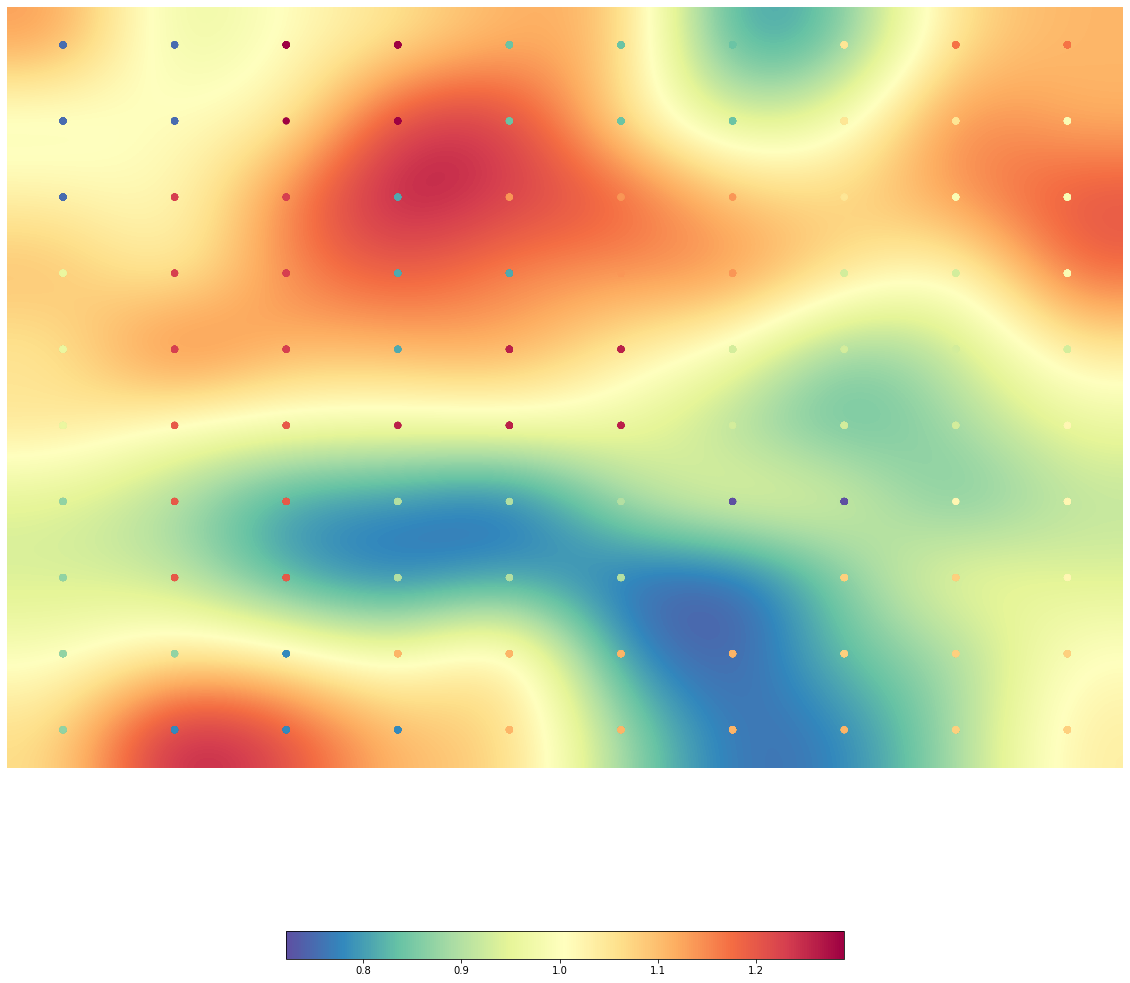

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [64]:
som.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)

In [65]:
clusters = som.clusters
print(clusters)

[[ 1  1 19 19  4  4  4 11 15 15]
 [ 1  1 19 19  4  4  4 11 11  9]
 [ 1 17 17  3 14 14 14 11  9  9]
 [ 8 17 17  3  3 14 14  7  7  9]
 [ 8 17 17  3 18 18  7  7  7  7]
 [ 8 16 16 18 18 18  7  7  7 10]
 [ 5 16 16  6  6  6  0  0 10 10]
 [ 5 16 16  6  6  6  6 12 12 10]
 [ 5  5  2 13 13 13 13 12 12 12]
 [ 5  2  2  2 13 13 13 13 12 12]]


#### Clusters Sorted by increasing number of Neurons(Cluser id: Number of Neurons):

In [66]:
cluster, neurons = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cluster, neurons))
cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
print(cl_info_sorted)

{0: 2, 15: 2, 8: 3, 2: 4, 3: 4, 9: 4, 10: 4, 11: 4, 19: 4, 1: 5, 5: 5, 14: 5, 18: 5, 4: 6, 16: 6, 17: 6, 6: 7, 12: 7, 13: 8, 7: 9}



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [67]:
def print_categories_stats(movies):
  print("Number of movies:", len(movies))
  all_categories = []
  for movie in movies:
    for category in categories[movie][0].split(',  '):
      all_categories.append(category)
  genre, genre_count = np.unique(all_categories, return_counts = True)
  genre_info = dict(zip(genre,genre_count))
  genre_info_sorted = { k: v for k, v in sorted(genre_info.items(), key = lambda item: item[1],reverse = True) }
  print(genre_info_sorted)   


In [68]:
def print_cluster_neurons_movies_report(clstr_id,clusters):
    neurons_list = []
    clusters_coords = np.where(clusters == clstr_id)
    bmus_arr = np.column_stack((clusters_coords[0], clusters_coords[1]))
    # bmus_arr = np.column_stack((clusters_coords[1],clusters_coords[0]))
    print("Number of neurons:", len(bmus_arr))
    for bmu_x, bmu_y in bmus_arr:
        if (bmu_x, bmu_y) in unique_bmus:
          neurons_list.append(bmu_x * clusters.shape[0] + bmu_y)
    return neurons_list

In [70]:
def neuron_movies_report(neurons):
  movie_list = []
  for neuron in neurons:
    movie_list.extend([i for i, e in enumerate(indices) if e in [neuron]])
  print_categories_stats(movie_list)


In [71]:
for i in range(20):
    print("Cluster id:", i)
    neuron_movies_report(print_cluster_neurons_movies_report(i,clusters))
    #print(print_categories_stats(neuron_movies_report(print_cluster_neurons_movies_report(i,clusters))))
    print('\n')

Cluster id: 0
Number of neurons: 2
Number of movies: 45
{'"Drama"': 33, '"Documentary"': 9, '"Black-and-white"': 7, '"Comedy film"': 7, '"Crime Fiction"': 4, '"Short Film"': 3, '"War film"': 3, '"Culture & Society"': 2, '"Film noir"': 2, '"Japanese Movies"': 2, '"Juvenile Delinquency Film"': 2, '"Melodrama"': 2, '"Musical"': 2, '"Prison"': 2, '"Teen"': 2, '"Thriller"': 2, '"Adventure"': 1, '"Americana"': 1, '"Backstage Musical"': 1, '"Biography"': 1, '"Biopic [feature]"': 1, '"Bollywood"': 1, '"Coming of age"': 1, '"Courtroom Drama"': 1, '"Doomsday film"': 1, '"Family Drama"': 1, '"Family Film"': 1, '"Fantasy"': 1, '"Film adaptation"': 1, '"Horror"': 1, '"Media Studies"': 1, '"Movie serial"': 1, '"Musical Drama"': 1, '"Mystery"': 1, '"Political cinema"': 1, '"Pre-Code"': 1, '"Propaganda film"': 1, '"Romantic comedy"': 1, '"Sci-Fi Thriller"': 1, '"Science Fiction"': 1, '"Silent film"': 1, '"Sports"': 1, '"Spy"': 1, '"Television movie"': 1, '"Tragedy"': 1, '"World cinema"': 1}


Cluster 

## Δοκιμές

### 2500 Ταινίες

In [72]:
f_set_2500 = build_final_set(corpus_w2v_model4, 2500)

#### **2500 Ταινίες, Χάρτη 20x20, 100 epochs**

In [73]:
rows = 20
columns = 20
som_20x20_2500 = somoclu.Somoclu(columns, rows, compactsupport = False)
%time som_20x20_2500.train(f_set_2500, epochs = 100)

CPU times: user 3min 13s, sys: 743 ms, total: 3min 14s
Wall time: 1min 43s


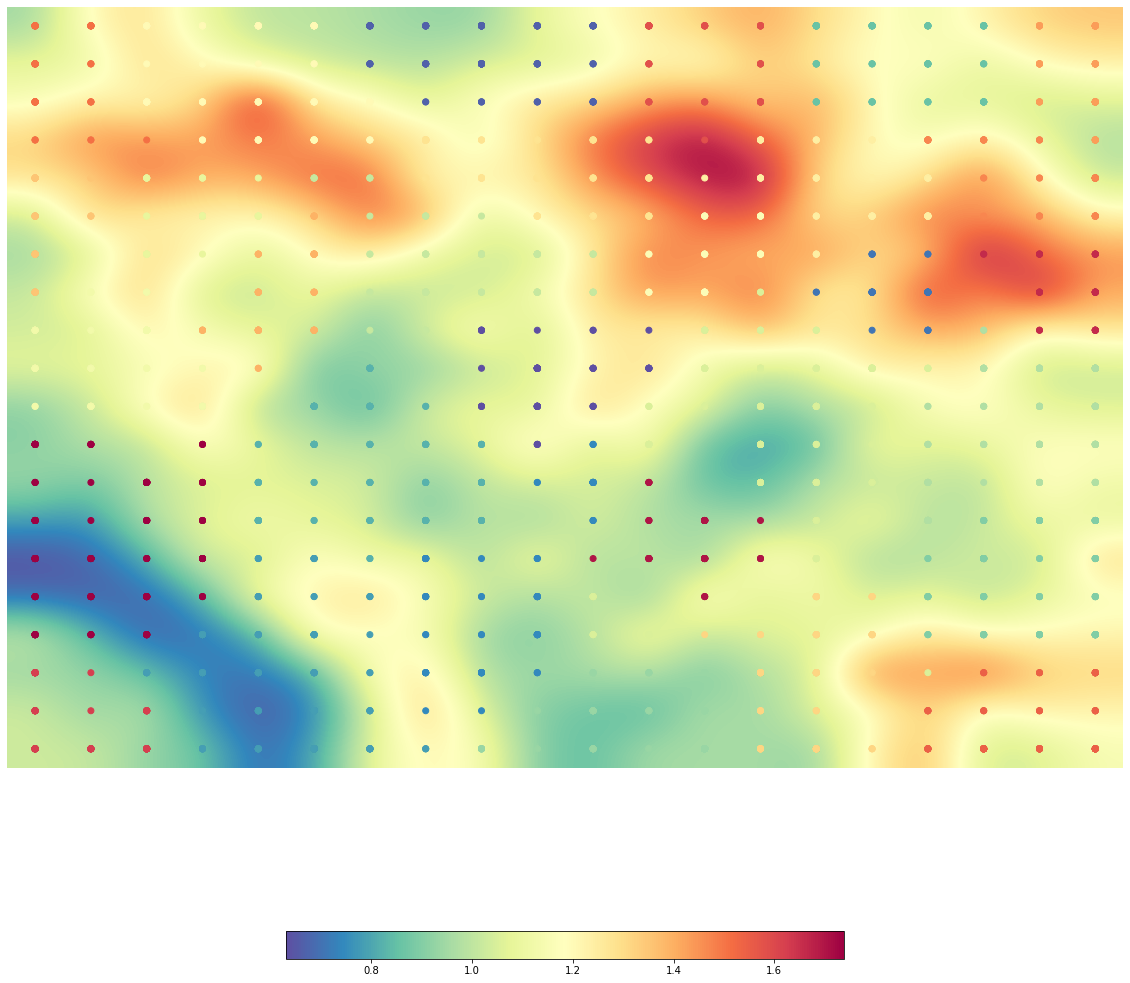

In [74]:
kmeans = KMeans(n_clusters = 30)
som_20x20_2500.cluster(algorithm = kmeans)
som_20x20_2500.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_20x20_30_2500 = som_20x20_2500.clusters

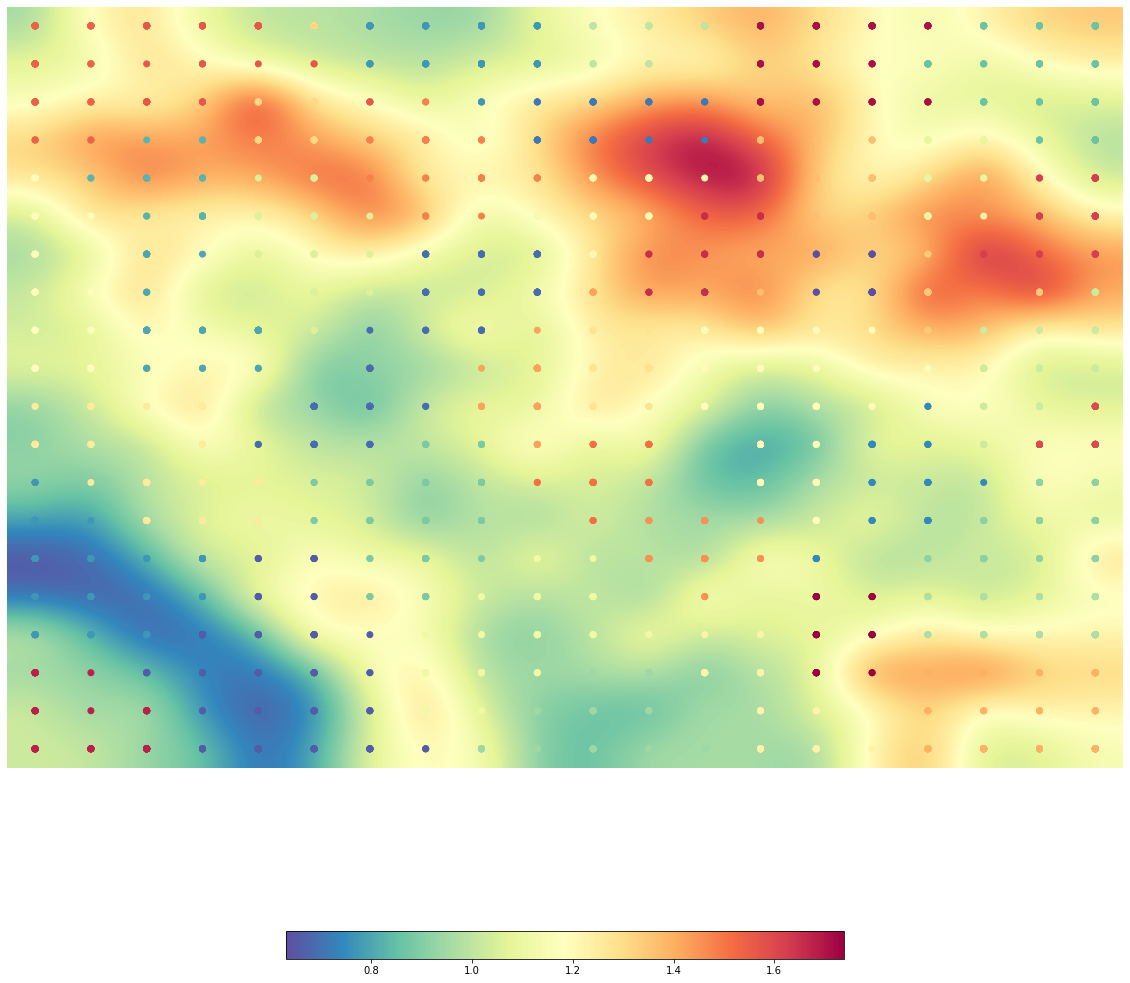

In [75]:
kmeans = KMeans(n_clusters = 40)
som_20x20_2500.cluster(algorithm = kmeans)
som_20x20_2500.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_20x20_40_2500 = som_20x20_2500.clusters

#### **2500 Ταινίες, Χάρτη 25x25, 100 epochs**

In [76]:
rows = 25
columns = 25
som_25x25_2500 = somoclu.Somoclu(columns, rows, compactsupport = False)
%time som_25x25_2500.train(f_set_2500, epochs = 100)

CPU times: user 5min 2s, sys: 1.12 s, total: 5min 3s
Wall time: 2min 43s


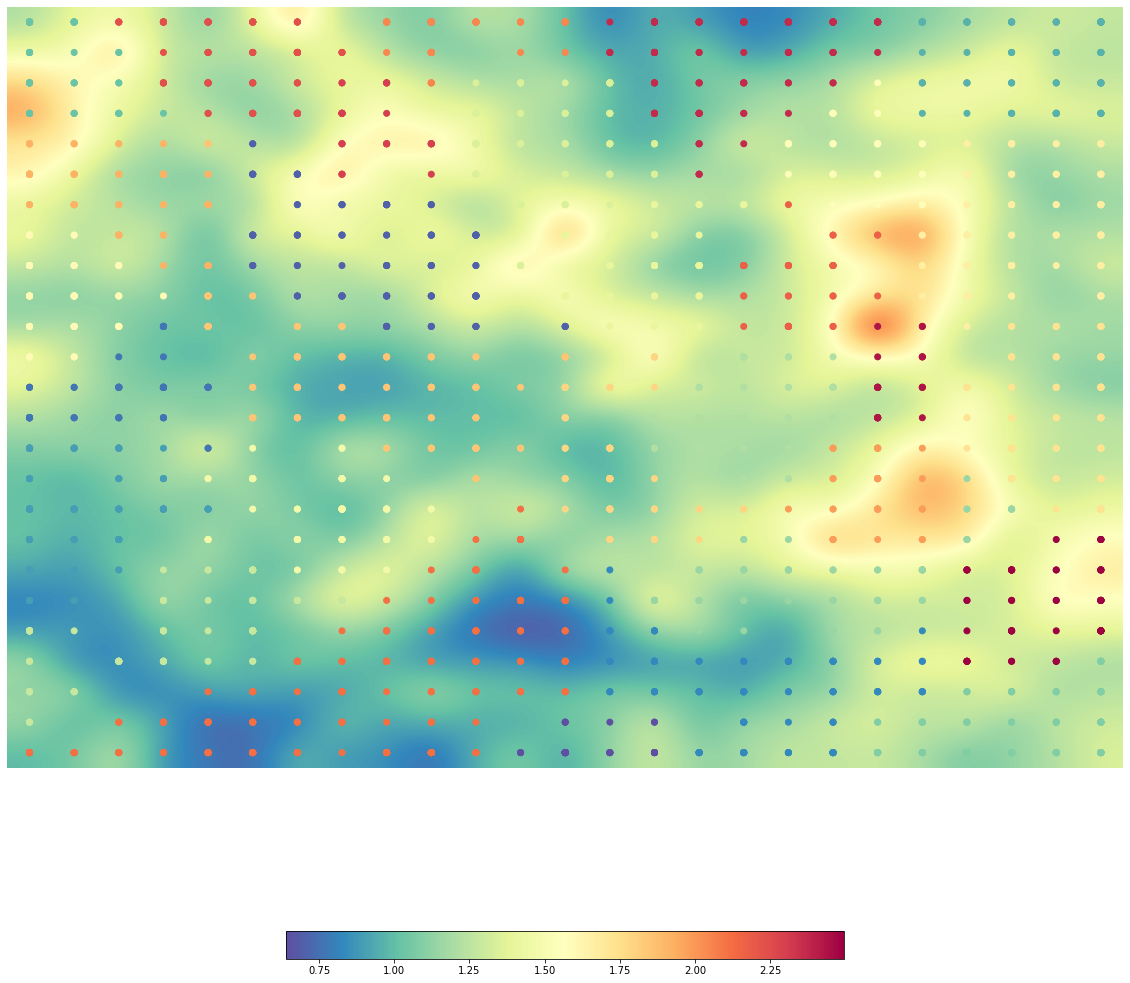

In [77]:
kmeans = KMeans(n_clusters = 30)
som_25x25_2500.cluster(algorithm = kmeans)
som_25x25_2500.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_25x25_30_2500 = som_25x25_2500.clusters

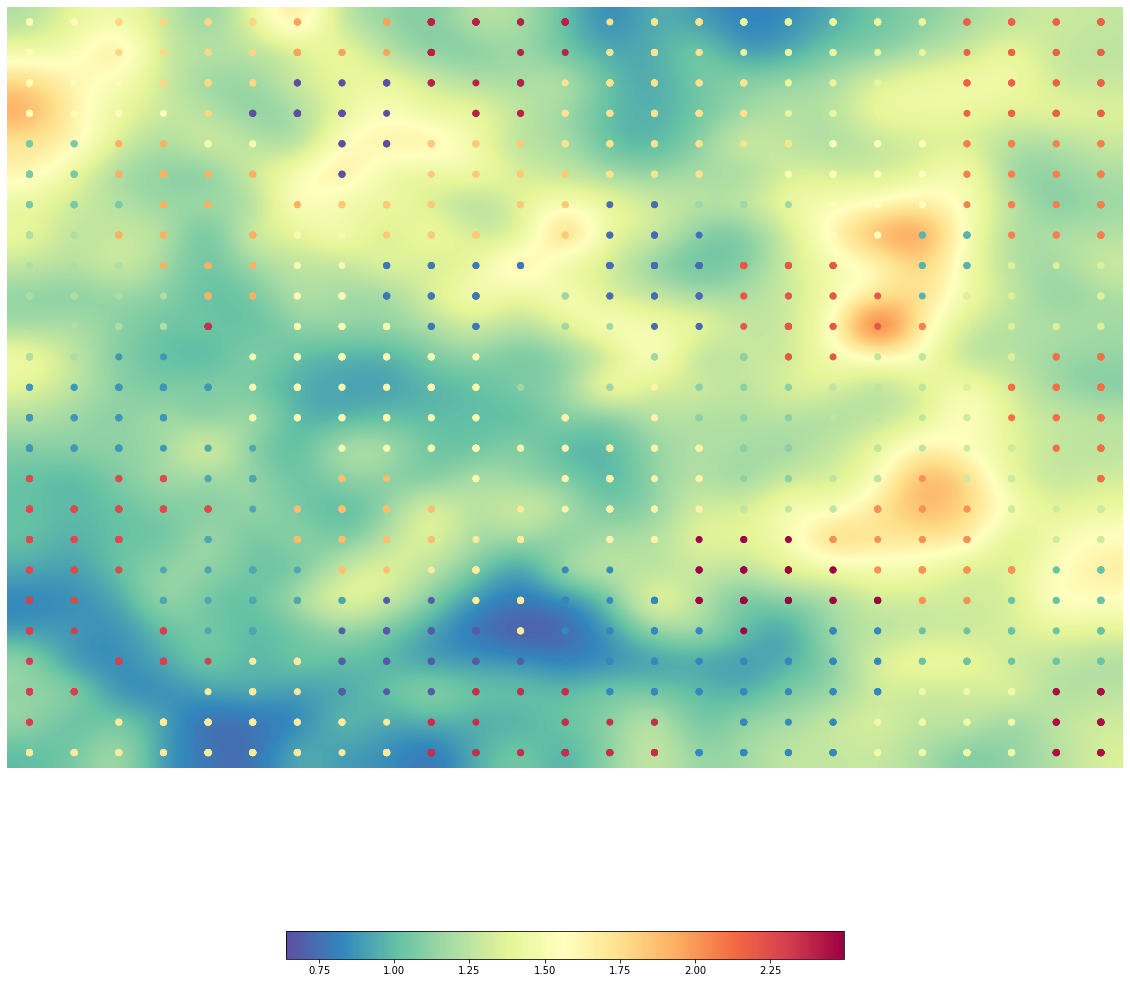

In [78]:
kmeans = KMeans(n_clusters = 40)
som_25x25_2500.cluster(algorithm = kmeans)
som_25x25_2500.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_25x25_40_2500 = som_25x25_2500.clusters

#### **2500 Ταινίες, Χάρτη 30x30, 100 epochs**

In [79]:
rows = 30
columns = 30
som_30x30_2500 = somoclu.Somoclu(columns, rows, compactsupport = False)
%time som_30x30_2500.train(f_set_2500, epochs = 100)

CPU times: user 7min 26s, sys: 1.63 s, total: 7min 28s
Wall time: 3min 51s


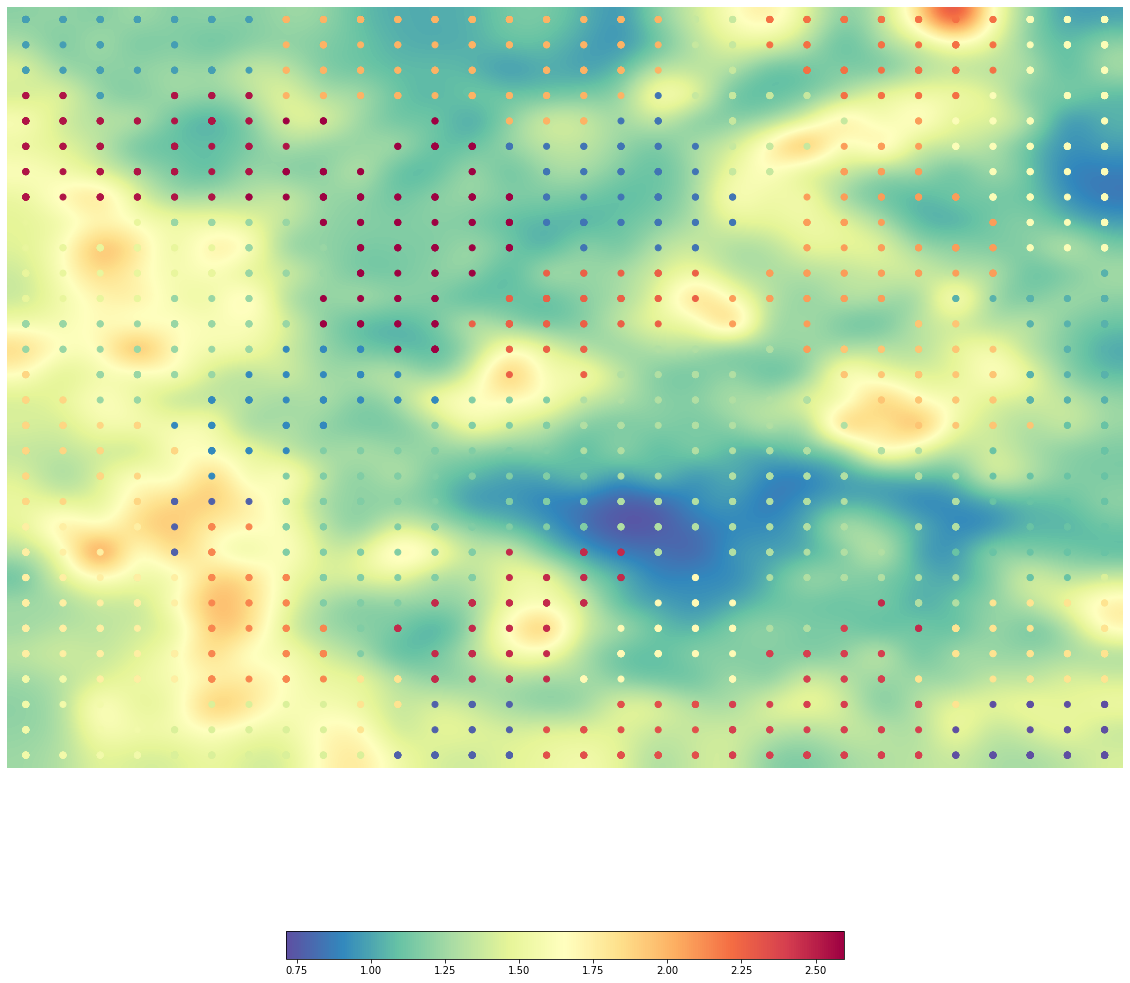

In [80]:
kmeans = KMeans(n_clusters = 30)
som_30x30_2500.cluster(algorithm = kmeans)
som_30x30_2500.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_30x30_30_2500 = som_30x30_2500.clusters

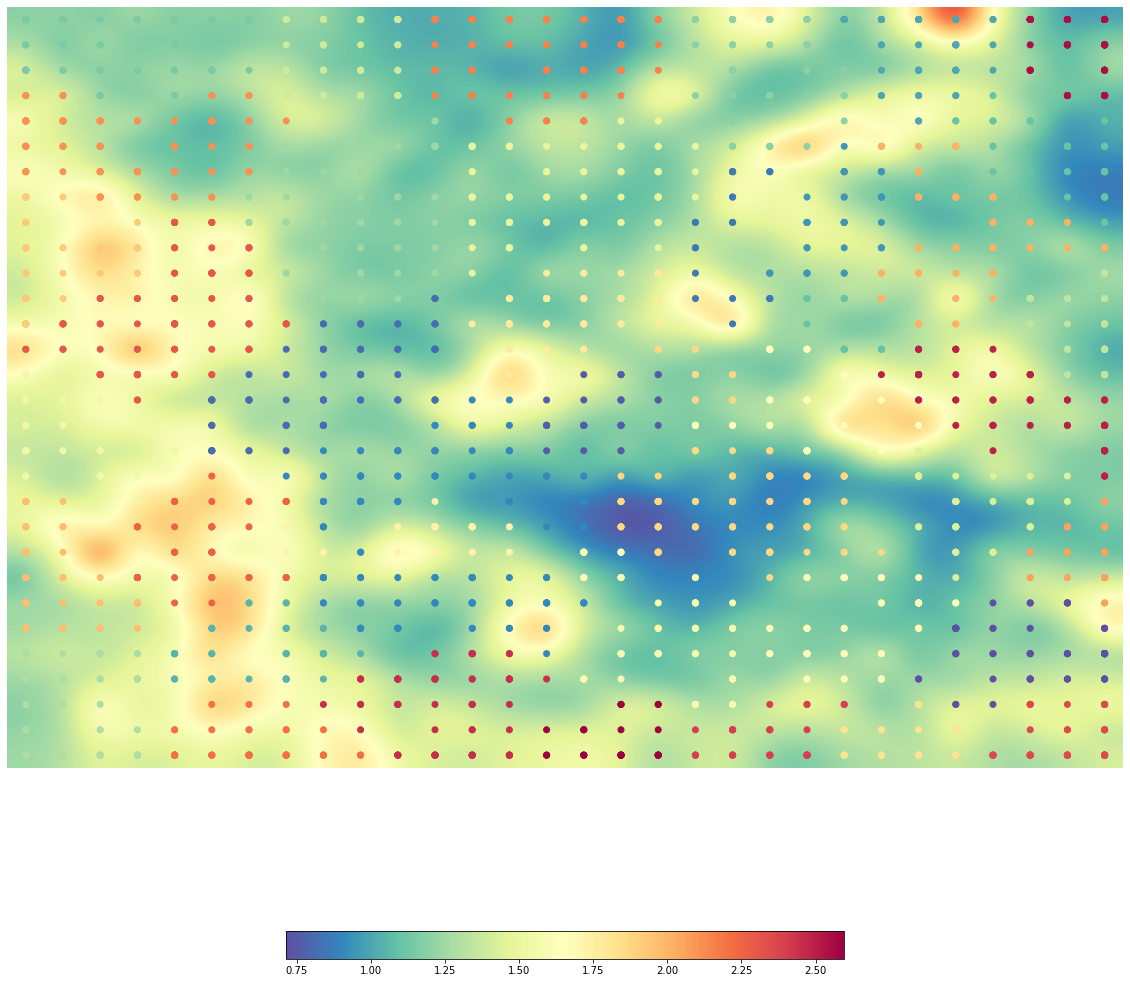

In [81]:
kmeans = KMeans(n_clusters = 40)
som_30x30_2500.cluster(algorithm = kmeans)
som_30x30_2500.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_30x30_40_2500 = som_30x30_2500.clusters

### 5000 Ταινίες

In [82]:
f_set_5000 = build_final_set(corpus_w2v_model4, 5000)

#### **5000 Ταινίες, Χάρτη 20x20, 100 epochs**

In [83]:
rows = 20
columns = 20
som_20x20_5000 = somoclu.Somoclu(columns, rows, compactsupport = False)
%time som_20x20_5000.train(f_set_5000, epochs = 100)

CPU times: user 6min 26s, sys: 1.25 s, total: 6min 28s
Wall time: 3min 22s


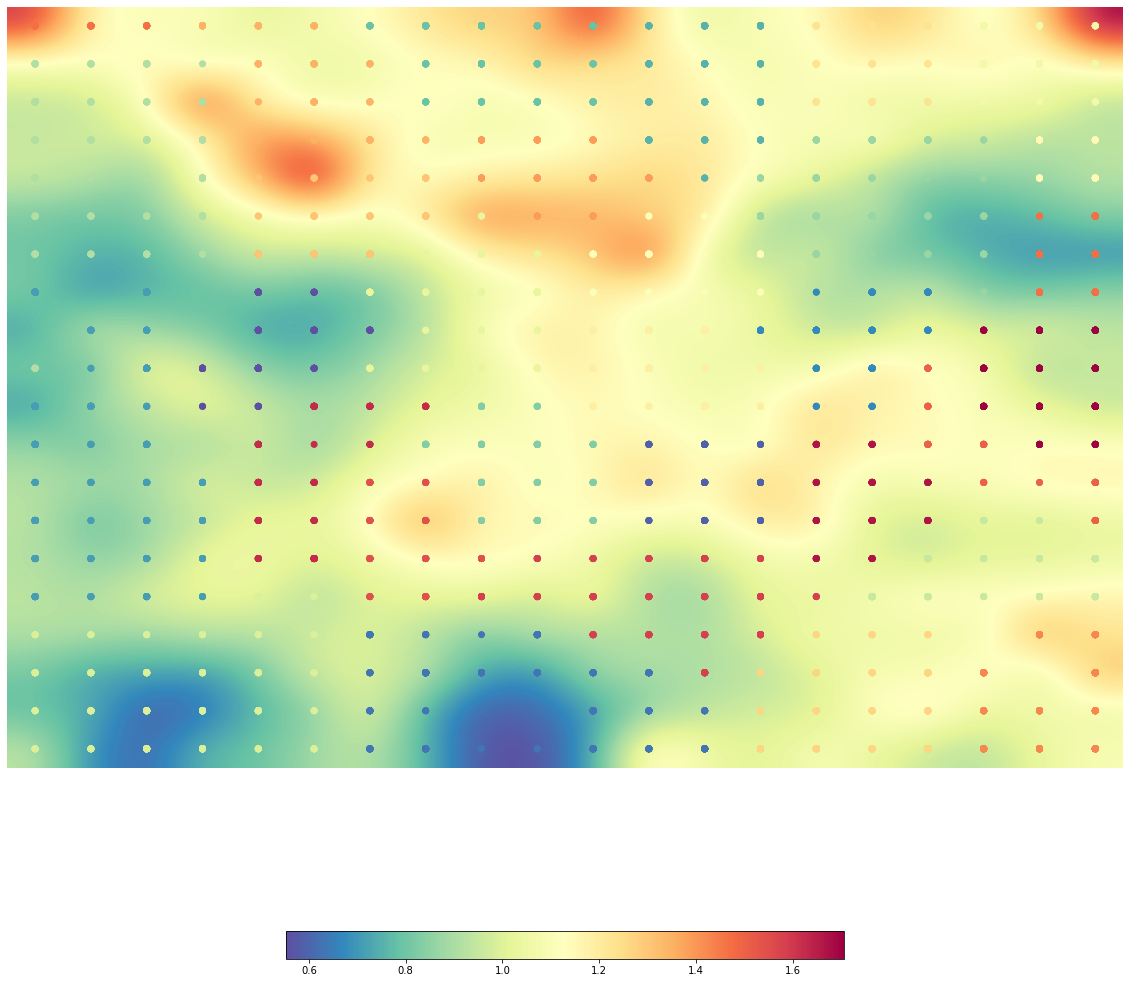

In [84]:
kmeans = KMeans(n_clusters = 30)
som_20x20_5000.cluster(algorithm = kmeans)
som_20x20_5000.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_20x20_30_5000 = som_20x20_5000.clusters

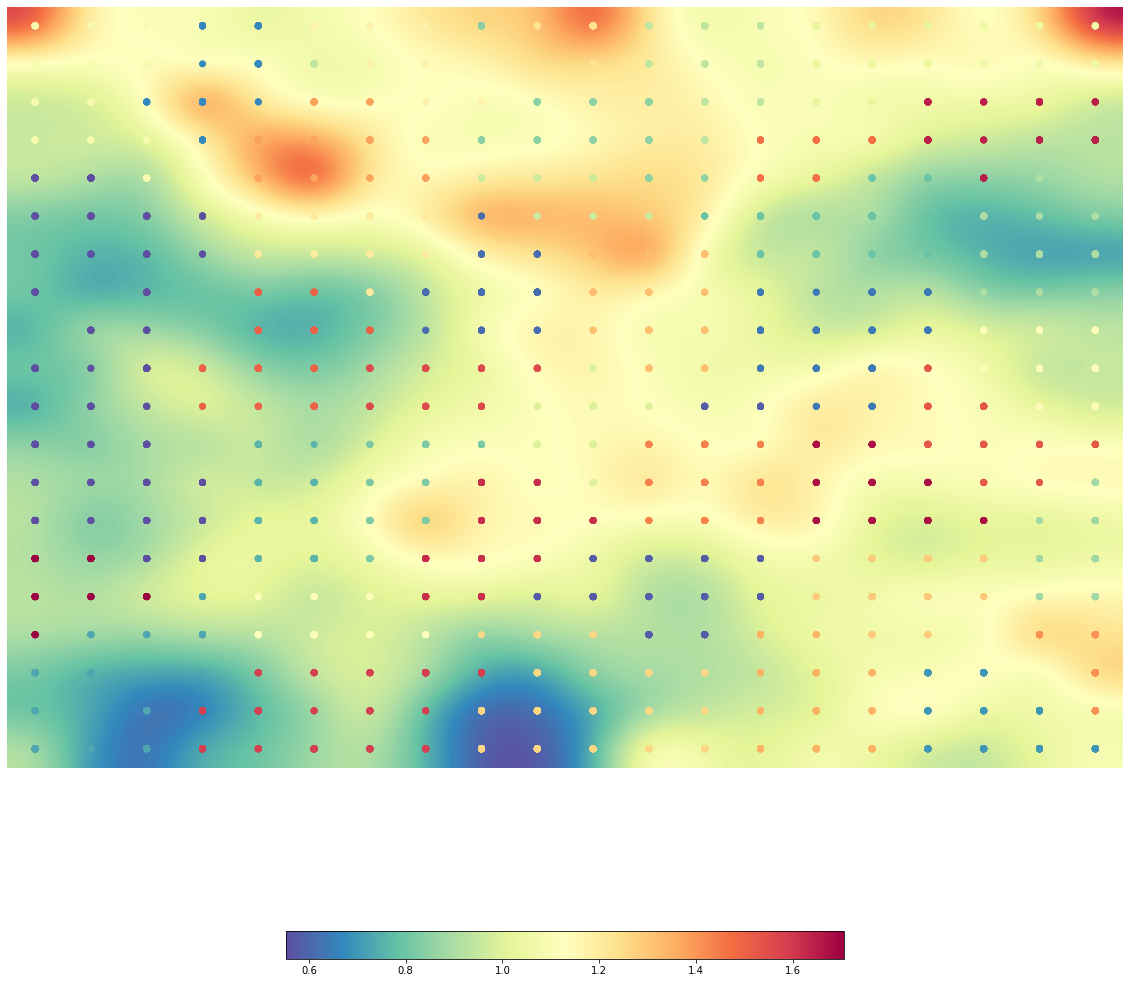

In [85]:
kmeans = KMeans(n_clusters = 40)
som_20x20_5000.cluster(algorithm = kmeans)
som_20x20_5000.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_20x20_40_5000 = som_20x20_5000.clusters

#### **5000 Ταινίες, Χάρτη 25x25, 100 epochs**

In [86]:
rows = 25
columns = 25
som_25x25_5000 = somoclu.Somoclu(columns, rows, compactsupport = False)
%time som_25x25_5000.train(f_set_5000, epochs = 100)

CPU times: user 10min 1s, sys: 2.13 s, total: 10min 3s
Wall time: 5min 18s


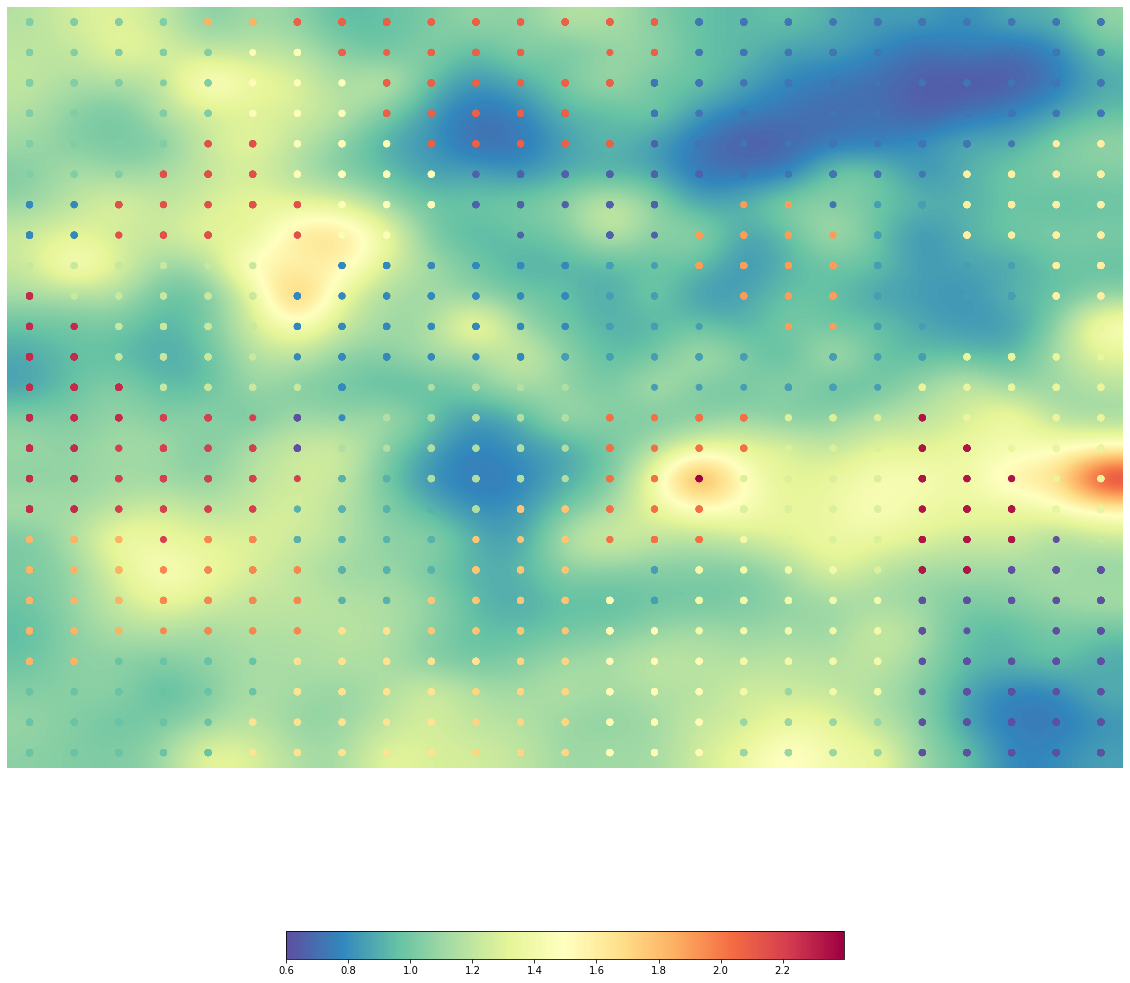

In [87]:
kmeans = KMeans(n_clusters = 30)
som_25x25_5000.cluster(algorithm = kmeans)
som_25x25_5000.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_25x25_30_5000 = som_25x25_5000.clusters

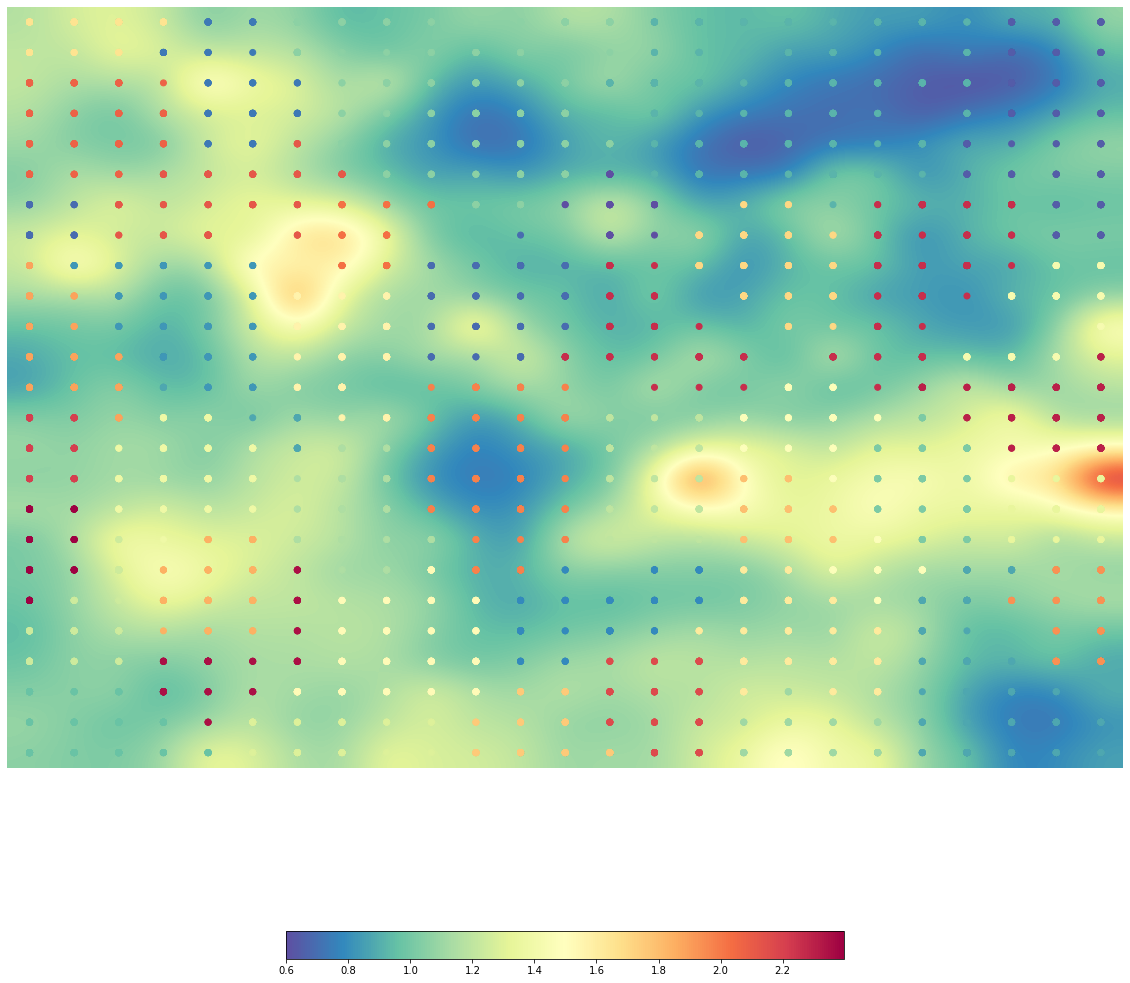

In [88]:
kmeans = KMeans(n_clusters = 40)
som_25x25_5000.cluster(algorithm = kmeans)
som_25x25_5000.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_25x25_40_5000 = som_25x25_5000.clusters

#### **5000 Ταινίες, Χάρτη 30x30, 100 epochs**

In [89]:
rows = 30
columns = 30
som_30x30_5000 = somoclu.Somoclu(columns, rows, compactsupport = False)
%time som_30x30_5000.train(f_set_5000, epochs = 100)

CPU times: user 14min 36s, sys: 3.08 s, total: 14min 39s
Wall time: 7min 38s


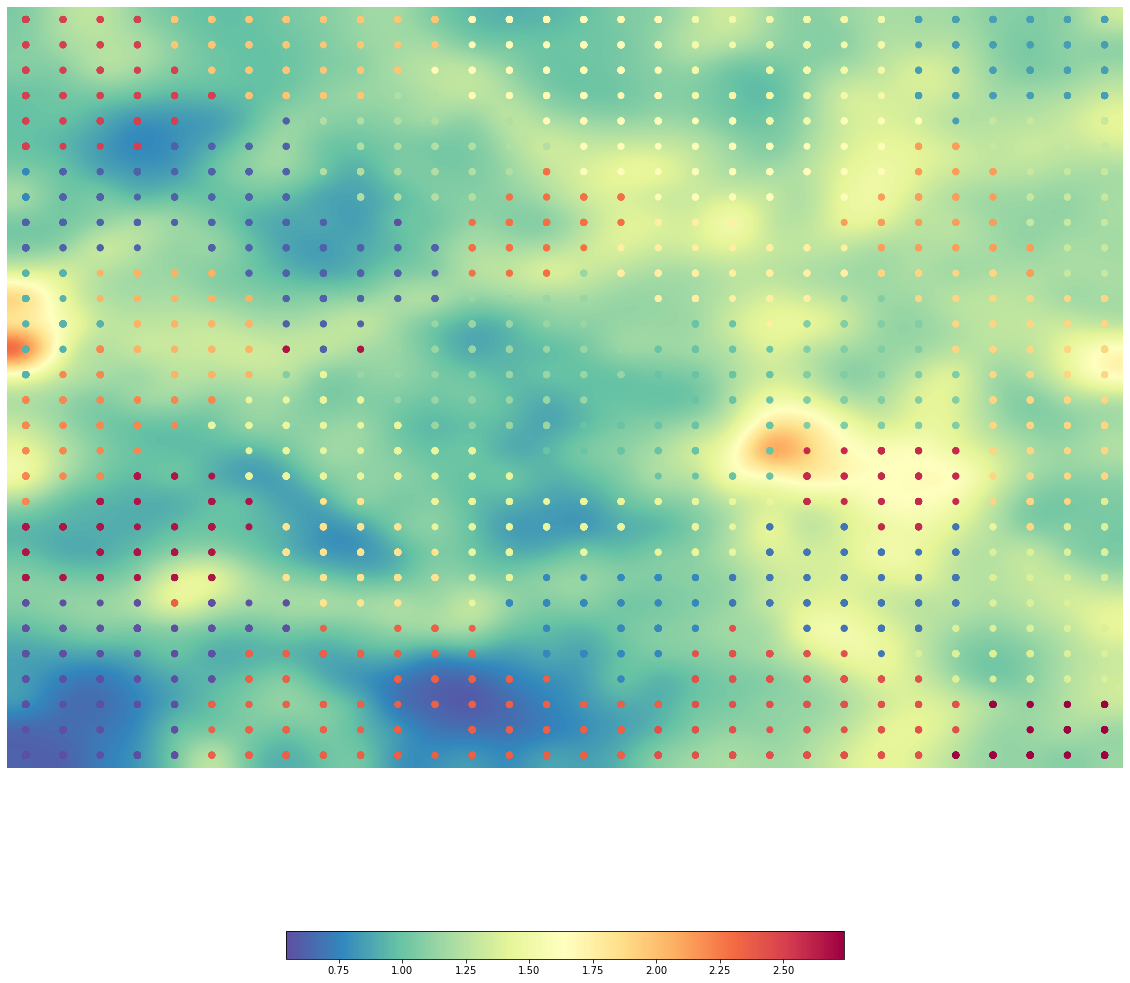

In [90]:
kmeans = KMeans(n_clusters = 30)
som_30x30_5000.cluster(algorithm = kmeans)
som_30x30_5000.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_30x30_30_5000 = som_30x30_5000.clusters

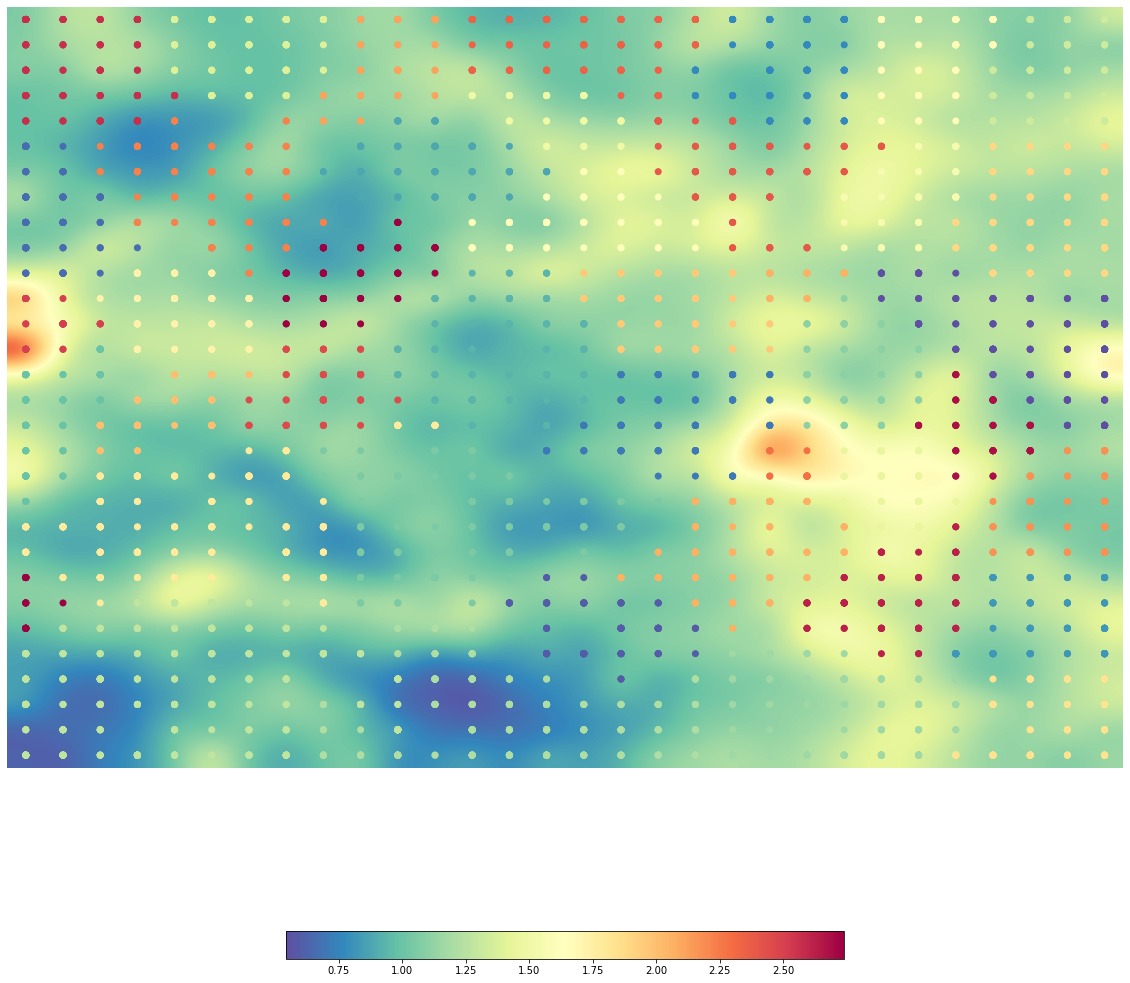

In [91]:
kmeans = KMeans(n_clusters = 40)
som_30x30_5000.cluster(algorithm = kmeans)
som_30x30_5000.view_umatrix(bestmatches = True, figsize = (20,20),colorbar = True)
clusters_30x30_40_5000 = som_30x30_5000.clusters

#### Παρατηρήσεις


Δοκιμάσαμε με τις εξής παραμέτρους:
*   2500 και 5000 ταινίες
*   Μέγεθος χάρτη: 20x20, 25x25 και 30x30
*   Αριθμός clusters: 30 και 40







*   Γενικά παρατηρούμε πως αυξάνοντας οποιαδήποτε απο αυτές τις παραμέτρους(αριθμός ταινιών, μέγεθος χάρτη, clusters) ο χρόνος εκπαίδευσης αυξάνεται.
*   Η αύξηση των clusters δεν αλλάζει το σχήμα του χάρτη αλλά κάνει πιο δύσκολη την διαφοροποίηση τους.





#### **Ο καλύτερος μας χάρτης είναι με 2500 ταινίες, 20x20 και k = 40 αφού φαίνεται να διακρίνονται πιο εύκολα όλες οι περιοχές.**

**Κατηγορίες για τον βέλτιστο μας χάρτη**

In [95]:
for i in range(40):
    print("Cluster id:", i)
    neuron_movies_report(print_cluster_neurons_movies_report(i,clusters_20x20_30_2500))
    #print(print_categories_stats(neuron_movies_report(print_cluster_neurons_movies_report(i,clusters))))
    print('\n')

Cluster id: 0
Number of neurons: 12
Number of movies: 0
{}


Cluster id: 1
Number of neurons: 14
Number of movies: 338
{'"Drama"': 232, '"Romance Film"': 137, '"Comedy"': 123, '"World cinema"': 67, '"Romantic comedy"': 53, '"Romantic drama"': 50, '"Musical"': 43, '"Indie"': 39, '"Comedy-drama"': 31, '"Bollywood"': 28, '"Action"': 27, '"Black-and-white"': 24, '"Period piece"': 22, '"Family Film"': 21, '"Film adaptation"': 16, '"Thriller"': 16, '"Adventure"': 14, '"Biographical film"': 14, '"Crime Fiction"': 14, '"Fantasy"': 13, '"Biopic [feature]"': 12, '"Black comedy"': 12, '"Family Drama"': 11, '"Biography"': 9, '"Art film"': 8, '"Japanese Movies"': 8, '"Science Fiction"': 8, '"Action/Adventure"': 7, '"Comedy of manners"': 7, '"Horror"': 7, '"Mystery"': 7, '"Short Film"': 7, '"Silent film"': 7, '"Chinese Movies"': 6, '"Costume drama"': 6, '"Melodrama"': 6, '"Music"': 6, '"Animation"': 5, '"Children\'s"': 5, '"Coming of age"': 5, '"Ensemble Film"': 5, '"Parody"': 5, '"Political drama"'

**Κατηφορίες και συχνότητες εμφάνισης:**

In [93]:
print(print_categories_stats([i for i in range(5000)]))

Number of movies: 5000
{'"Drama"': 2245, '"Comedy"': 1295, '"Romance Film"': 791, '"Thriller"': 765, '"Action"': 749, '"World cinema"': 612, '"Crime Fiction"': 492, '"Horror"': 477, '"Black-and-white"': 472, '"Action/Adventure"': 454, '"Adventure"': 443, '"Family Film"': 431, '"Short Film"': 393, '"Indie"': 385, '"Animation"': 307, '"Romantic drama"': 300, '"Musical"': 289, '"Science Fiction"': 288, '"Fantasy"': 244, '"Romantic comedy"': 244, '"Mystery"': 242, '"Comedy film"': 228, '"Crime Thriller"': 204, '"War film"': 186, '"Comedy-drama"': 168, '"Period piece"': 164, '"Silent film"': 149, '"Japanese Movies"': 141, '"Film adaptation"': 136, '"Documentary"': 134, '"Psychological thriller"': 132, '"Bollywood"': 130, '"Western"': 122, '"Chinese Movies"': 121, '"Children\'s/Family"': 97, '"Black comedy"': 94, '"Teen"': 94, '"Parody"': 91, '"Sports"': 87, '"Cult"': 85, '"Martial Arts Film"': 84, '"Biographical film"': 80, '"Slasher"': 80, '"Suspense"': 77, '"Television movie"': 76, '"Slap

#### **Μελέτη Βέλτιστου χάρτη SOM**

Ως ο καλύτερος χάρτης επιλέχθηκε ο χάρτης με 2500 ταινίες, διαστάσεις 20x20 και αριθμό clusters ίσο με 40 αφού είναι πιό ευδιάκριτες οι κόκκινες και οι μπλέ περιοχές.

Δεν έχουν όλλα τα clusters ταινίες, συγκεκριμένα μόνο 12 απο αυτά. Κάποιες κατηγορίες έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες, κάτι που σημαίνει πως τα clusters διαθέτουν καλή συνοχή και εξειδίκευση.

Πιο κάτων φαίνονται τα 12 clusters με τις επικρατέστερες κατηγορίες τους:

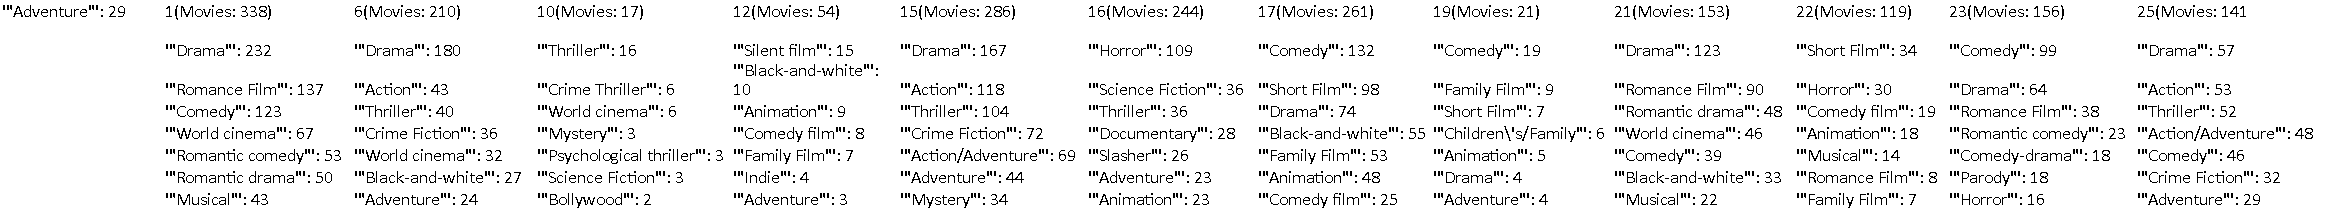

Συμπεράσματα:

*   Οι πιό συχνές κατηγορίες είναι οι Drama και Comedy
*   Τα clusters τα οποία έχουν πολλές κοινές κατηγορίες εμφανίζονται κοντά στον χάρτη. Για παράδειγμα κατηγορίες με drama και comedy φαίνεται να βρίσκονται κοντά
*   Κάποιες κατηγορίες είναι πολύ σπάνιες αφού ταινίες με αυτο το genre είναι επίσης πολύ λίγες. Για αυτό το λόγο, δεν υπάρχει αρκετή πληροφορία ώστε να αποφασιστεί το είδος τους. Κάποιες απο αυτές τις κατηγορίες είναι οι "Rockumentary", "Space opera", "Steampunk" κτλ.
*   Κάποιες κατηγορίες δεν μπορούν να προσδιοριστούν απο την περιγραφή τους όπως είναι οι Black and white και σε κάποιες περιπτώσεις Filipino Movies, Stop Motion κτλ.
*   Κάποια cluster είναι πολύ κοντά μεταξύ τους και είναι σε γειτονικές περιοχές όπως τα 15,16 και 17.
*   Κάποια clusters στα οποία επικρατούν κάποιες κατηγορίες θα μπορούσαν να χαρακτηριστούν και απο αυτές. Όπως το cluster 1 με κατηγορίες Drama-Romance Film, cluster 10 με κατηγορία Thriller, cluser 17 Comedy-Short Film.
*   Κάποιες κατηγορίες που μοιάζουν είναι πολύ κοντα μεταξύ τους και βρίσκονται στο ίδιο cluster όπως Thriller - Crime Thriller (στο cluster 10) και Romance Film - Romantic Drama (στο cluster 21).






## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.



# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>